In [1]:
!pip install jupyter numpy torch torchvision torchaudio pillow matplotlib opencv-python
!pip install transformers sentencepiece accelerate


   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.0 MB ? eta -:--:--
    --------------------------------------- 0.5/39.0 MB 2.0 MB/s eta 0:00:19
   - -------------------------------------- 1.0/39.0 MB 2.2 MB/s eta 0:00:18
   - -------------------------------------- 1.6/39.0 MB 2.3 MB/s eta 0:00:17
   -- ------------------------------------- 2.1/39.0 MB 2.3 MB/s eta 0:00:17
   -- ------------------------------------- 2.6/39.0 MB 2.4 MB/s eta 0:00:16
   --- ------------------------------------ 3.4/39.0 MB 2.6 MB/s eta 0:00:14
   ---- ----------------------------------- 4.2/39.0 MB 2.6 MB/s eta 0:00:14
   ---- ----------------------------------- 4.7/39.0 MB 2.7 MB/s eta 0:00:13
   ----- ---------------------------------- 5.8/39.0 MB 2.8 MB/s eta 0:00:12
   ------ --------------------------------- 6.6/39.0 MB 3.0 MB/s eta 0:00:11
   ------- -------------------------------- 7.3/39.0 MB 3.1 MB/s eta 0:00:11
   -------- -

Using device: cpu


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 0446bba0-1733-49d6-9a9c-f5534c9cc4e4)')' thrown while requesting HEAD https://huggingface.co/nlpconnect/vit-gpt2-image-captioning/resolve/main/config.json
Retrying in 1s [Retry 1/5].
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


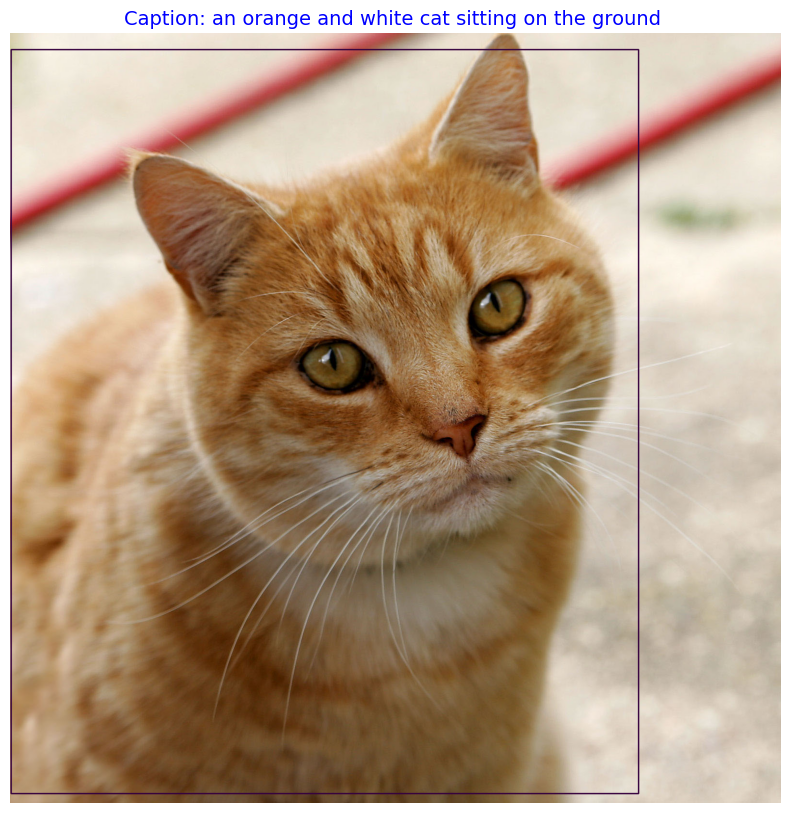

In [3]:
# ===========================
# 📦 Import Libraries
# ===========================
import numpy as np
import torch
import torchvision
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Hugging Face (for captioning)
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

# ===========================
# ⚙️ Device Setup
# ===========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===========================
# 📝 Image Captioning Setup
# ===========================
caption_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to(device)
caption_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
caption_tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

def generate_caption(image_path):
    image = Image.open(image_path).convert("RGB")
    pixel_values = caption_processor(images=image, return_tensors="pt").pixel_values.to(device)
    output_ids = caption_model.generate(pixel_values, max_length=16, num_beams=4)
    caption = caption_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return caption

# ===========================
# 🎯 Image Segmentation Setup
# ===========================
segment_model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)
segment_model.eval()

def segment_image(image_path, threshold=0.8):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    img = transform(image).to(device)

    with torch.no_grad():
        predictions = segment_model([img])

    prediction = predictions[0]
    masks = prediction["masks"].cpu().numpy()
    boxes = prediction["boxes"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()

    return image, masks, boxes, labels, scores

# ===========================
# 🎨 Visualization
# ===========================
def visualize_results(image_path):
    caption = generate_caption(image_path)
    image, masks, boxes, labels, scores = segment_image(image_path)

    # Convert to NumPy for OpenCV overlay
    img_np = np.array(image)

    for i in range(len(masks)):
        if scores[i] > 0.8:
            mask = masks[i, 0]
            mask = (mask > 0.5).astype(np.uint8) * 255

            # Random color for mask
            color = np.random.randint(0, 255, (3,), dtype=np.uint8)
            colored_mask = np.zeros_like(img_np, dtype=np.uint8)
            for c in range(3):
                colored_mask[:, :, c] = mask * color[c] // 255

            # Overlay mask
            img_np = cv2.addWeighted(img_np, 1, colored_mask, 0.5, 0)

            # Draw bounding box
            x1, y1, x2, y2 = boxes[i].astype(int)
            cv2.rectangle(img_np, (x1, y1), (x2, y2), color.tolist(), 2)

    # Show with caption
    plt.figure(figsize=(10, 10))
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"Caption: {caption}", fontsize=14, color="blue")
    plt.show()

# ===========================
# 🚀 Run Example
# ===========================
image_path ="C:/Users/Admin/Downloads/Cat03.jpg"  # 🔹 Replace with your image
visualize_results(image_path)
